In [1]:
import pickle
from lime import lime_tabular
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import shap
from collections import namedtuple, OrderedDict
from sklearn.metrics import mean_squared_error,precision_score, recall_score, accuracy_score, f1_score
import os

%run myxgboost_model.ipynb
%matplotlib inline

Possible set intersection at position 3


## LIME:

### LIME class:

In [2]:
class LIMExplain:
    def __init__(self, fitted_model, X_train: pd.DataFrame, Y_train: pd.DataFrame, feature_names: list, target: list,
                 c_features: list or None, discretize_continuous):
        self.X_train = X_train
        self.model = fitted_model
        self.feature_names = feature_names
        self.target = target
        self.explainer = lime_tabular.LimeTabularExplainer(X_train.values, training_labels=Y_train, feature_names=feature_names,
                                                           class_names=target, categorical_features=c_features, verbose=True,
                                                           mode='classification', discretize_continuous=discretize_continuous, random_state=10)

    def lime_explain(self, test_set, indices, test_labels, n_features=10, do_plot=True, plot_path=None):
        """
        mode: regression or classification
        kernel_width: kernel width for the exponential kernel.
                    If None, defaults to sqrt (number of columns) * 0.75
        feature_selection: feature selection method. can be
                    'forward_selection', 'lasso_path', 'none' or 'auto'.
                    See function 'explain_instance_with_data' in lime_base.py for
                    details on what each of the options does.
        """
        exps = []
        labels = []
        predictions = []
        for inx in indices:
            labels.append(test_labels.values[inx])
            print(f'\n##Explaining sample {inx} :')
            exp = self.explainer.explain_instance(np.array(test_set.values[inx]), self._xgb_prediction, 
                                                  num_features=n_features)
            exps.append(exp)
        if do_plot:
            fig, ax = plt.subplots(1, len(indices), figsize=(13, 10))
            plt.subplots_adjust(left=0.05, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
            for ix, exp in enumerate(exps):
                axis = ax[ix] if isinstance(ax,(list, np.ndarray)) else ax 
                results = exp.as_list()
                survive = np.sum([y for (x,y) in results if y >= 0])
                die = np.sum([y for (x,y) in results if y < 0])
                print(f'Sample {inx}, Evidences to survive:{survive}, evidence to die:{die}')
                feature = [val[0] for val in results]
                values = [val[1] for val in results]
                self.plot_explanation(values, feature, axis, indices[ix], labels[ix], exps[0], plot_path)
            plt.show()
        return exps, predictions, labels

    def _xgb_prediction(self, X_array_in):
        if len(X_array_in.shape) < 2:
            X_array_in = np.expand_dims(X_array_in, 0)
        return self.model.predict_proba(X_array_in, validate_features=False)

    @staticmethod
    def plot_explanation(values, feature, myax, sample_num, label, exp, plot_path):
        y_pos = np.arange(len(values))
        colors = ['r' if v < 0 else 'g' for v in values]
        myax.barh(y_pos, values, align='center', color=colors)
        myax.set_yticks(y_pos)
        myax.set_yticklabels(feature)
        myax.invert_yaxis()  # labels read top-to-bottom
        myax.set_title(f'Sample number {sample_num}, True label: {label[0]}\nGlobal prediction: {exp.predict_proba[1]:.2f},\n Local prediction: {exp.local_pred[0]:.2f}', fontsize=16)
        plt.rc('font', size=18) 
        plt.tight_layout()
        if plot_path:
            plt.savefig(os.path.join(plot_path, 'local_lime_' + str(sample_num)))

### Train a model:

In [3]:
# Train xgboost model:
train = pd.read_csv("../input/Titanic/train_processed_nonohe.csv")
mytest = pd.read_csv("../input/Titanic/mytest_processed_nonohe.csv")

# Drop passenger id:
mytest.drop(labels=["PassengerId"], axis=1, inplace=True)
train.drop(labels=["PassengerId"], axis=1, inplace=True)

train["Survived"] = train["Survived"].astype(int)
mytest["Survived"] = mytest["Survived"].astype(int)
y_train = train[["Survived"]]
X_train = train.drop(labels=["Survived"], axis=1)
y_test = mytest[["Survived"]]
X_test = mytest.drop(labels=["Survived"], axis=1)


path_result=None
xgb_model = XgboostModel(X_train, y_train, X_test, y_test, optimized_params=True)
xgb_model.train(path_result, do_hps=False, do_split=False, do_save=False, do_print=True, seed=42)

Training...
Preforming prediction of the test data
Precision: 0.8307692307692308, Accuaracy: 0.8770949720670391, Recall: 0.8307692307692308, F1_score: 0.8307692307692308


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


### Cases:


##Explaining sample 4 :
Intercept 0.9089063544810594
Prediction_local [0.22450862]
Right: 0.12906277
Sample 4, Evidences to survive:0.1840660160883126, evidence to die:-0.8684637482599163


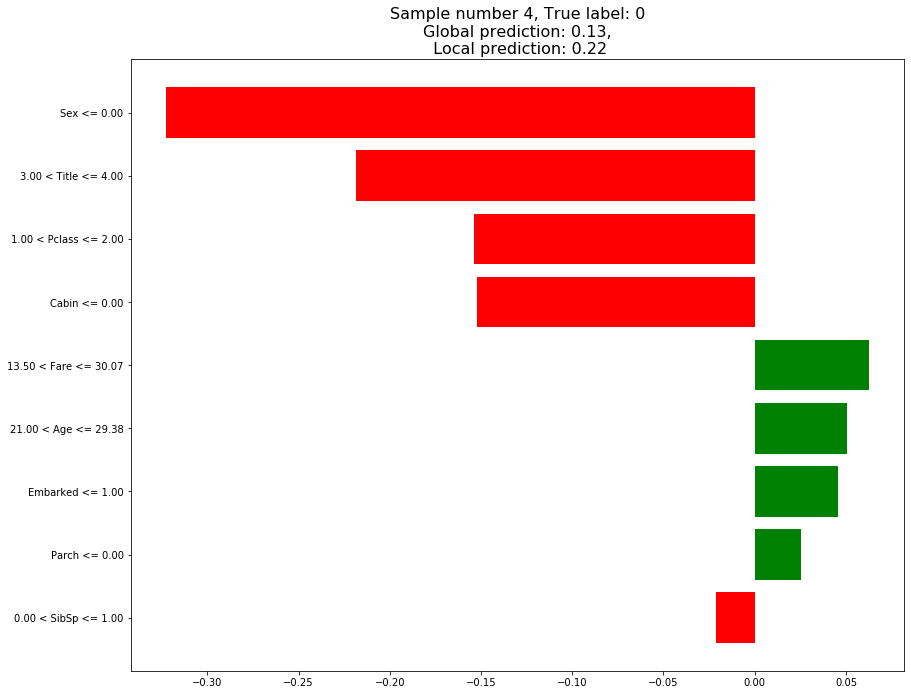

In [4]:
c_features = ['Cabin', 'Sex', 'Pclass', 'Embarked', 'Title']
lexplain = LIMExplain(xgb_model.xg_class, X_train, y_train, X_train.columns.to_list(), ['Died', 'Survived'], c_features=c_features,
                      discretize_continuous=True)
[exps, predictions, labels] = lexplain.lime_explain(X_test, [4], y_test, n_features=10, do_plot=True, plot_path ='/storage/blogs/Explainability/xgboost')


##Explaining sample 35 :
Intercept 0.829799794386036
Prediction_local [0.3119014]
Right: 0.6413309
Sample 35, Evidences to survive:0.32567747268448577, evidence to die:-0.8435758656547804


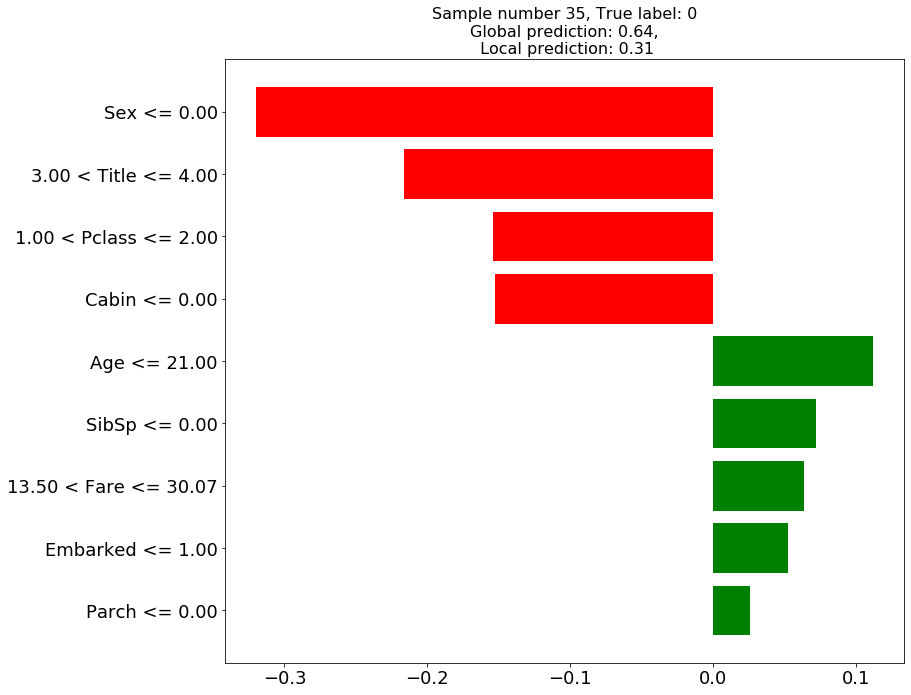

In [5]:
c_features = ['Cabin', 'Sex', 'Pclass', 'Embarked', 'Title']
lexplain = LIMExplain(xgb_model.xg_class, X_train, y_train, X_train.columns.to_list(), ['Died', 'Survived'], c_features=c_features,
                      discretize_continuous=True)
[exps, predictions, labels] = lexplain.lime_explain(X_test, [35], y_test, n_features=10, do_plot=True, plot_path ='/storage/blogs/Explainability/xgboost')

### 2. Compare different K's (num of features):

#### Load data:


##Explaining sample 42 :
Intercept 0.34563060957762165
Prediction_local [0.70730251]
Right: 0.37952757

##Explaining sample 42 :
Intercept 0.43976696335698073
Prediction_local [0.75044372]
Right: 0.37952757

##Explaining sample 42 :
Intercept 0.4043471331991668
Prediction_local [0.84323122]
Right: 0.37952757

##Explaining sample 42 :
Intercept 0.3828830431854623
Prediction_local [0.84945206]
Right: 0.37952757


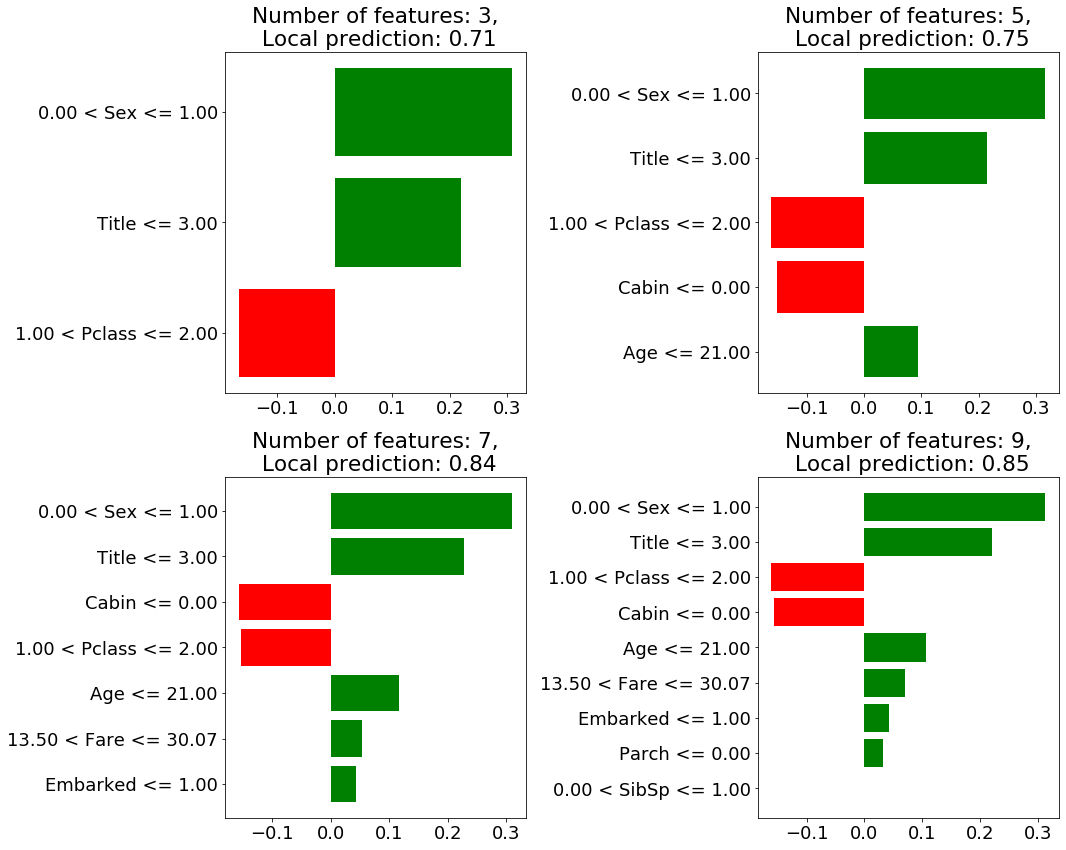

In [6]:
c_features = ['Cabin', 'Sex', 'Pclass', 'Embarked', 'Title']
all_features = X_train.columns
sample_num = 42
num_features = [3,5,7,len(all_features)]
lexplain = LIMExplain(xgb_model.xg_class, X_train, y_train, X_train.columns.to_list(), ['Survived'], c_features=c_features,
                      discretize_continuous=True)

fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax = ax.flatten()
for i, n in enumerate(num_features):
    [exp, predictions, labels] = lexplain.lime_explain(X_test, (sample_num,), y_test, n_features=n, do_plot=False) 
    exp = exp[0]
    results = exp.as_list()
    feature = [val[0] for val in results]
    values = [val[1] for val in results]
    
    plt.subplots_adjust(left=0.05, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    axis = ax[i]    
    y_pos = np.arange(len(values))
    colors = ['r' if v < 0 else 'g' for v in values]
    axis.barh(y_pos, values, align='center', color=colors)
    axis.set_yticks(y_pos)
    axis.set_yticklabels(feature)
    axis.invert_yaxis()  # labels read top-to-bottom
    axis.set_title(f'Number of features: {n},\n Local prediction: {exp.local_pred[0]:.2f}')
    
plt.rc('font', size=13) 
plt.tight_layout()
    
    

## SHAP:

### Cases:

In [7]:
# initialize js:
shap.initjs()
explainer = shap.TreeExplainer(xgb_model.xg_class, feature_perturbation = "tree_path_dependent")
shap_values = explainer.shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.


In [8]:
inx = 35
prediction = xgb_model.xg_class.predict(np.expand_dims(X_test.values[inx], 0), validate_features=False)
label = y_test.values[inx]
print(f'The true label pf the sample: {label[0]}, the prediction: {prediction[0]}')
shap.force_plot(explainer.expected_value, shap_values[inx,:], X_test.iloc[inx,:], link=shap.common.LogitLink(), figsize=(50,15), text_rotation=90)


The true label pf the sample: 0, the prediction: 1


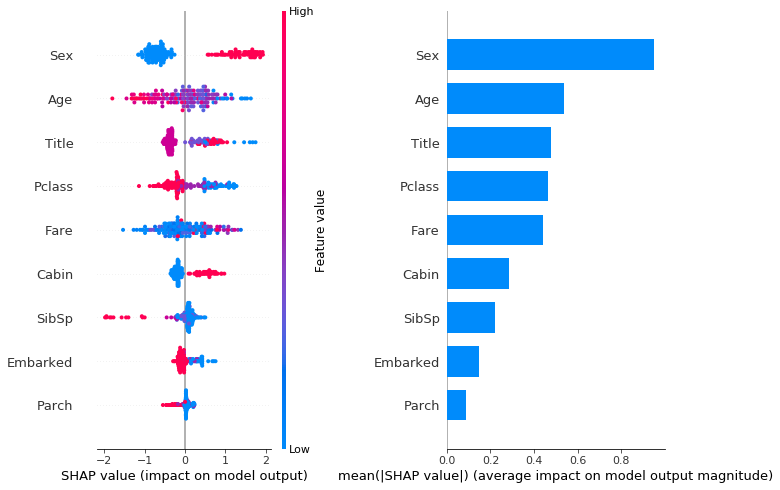

In [9]:
plt.subplot(121)
shap.summary_plot(shap_values, X_test, show=False, plot_size=(25,10))
plt.subplot(122)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False,  plot_size=(11,7))
plt.subplots_adjust(left=0.0002, bottom=None, right=None, top=None, wspace=1.2, hspace=None)
plt.tight_layout()
